In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sympy import (
    Derivative, 
    S, 
    Symbol, 
    series, 
    sqrt, 
    symbols, 
    oo, 
    limit, 
    Rational, 
    cos, 
    sin, 
    cosh, 
    sinh, 
    Matrix, 
    simplify, 
    latex, 
    lambdify,
    Function,
    collect,
    lambdify,
    solve,
    Eq
    
)
import numpy as np
import pandas as pd
from sympy import init_printing
init_printing() 

from sympy.printing.latex import print_latex
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook
from pymad_hzb.PlotTools import new_plot_elems_madx
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
from acchamiltoniansandmatrices.Matrices.SymbMatrices import (
    RsymbFODO, 
    RsymbDrift6D, 
    RsymbQuad6D, 
    RsymbQuad6DChroma, 
    RsymbQuad6DThin
)
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import (
    RnpFODO, 
    RnpDrift6D, 
    RnpQuad6D, 
    RnpQuad6DChroma, 
    RnpQuad6DThin
)
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import (
    HamDrift6D, 
    HamDrift6DParaxialSecondOrder, 
    HamQuad6D, 
    HamQuad6DParaxialSecondOrder, 
    HamQuad6DParaxialSecondOrderChroma,
)
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, LinMap, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket

In [5]:
x, px, y, py, z, delta, eps, h , k0, k1, k2, sigma, betag ,f = symbols('x p_x y p_y z delta epsilon h k_0 k_1 k_2 sigma beta_gamma f', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)

# General assumptions

In order to minimize the cluttering of equations the following approximations will be used:
$$\frac{1}{\beta_0^2\gamma_0^2} \rightarrow 0 \\
\beta_0 \rightarrow 1
$$


# Introduction

Before starting the effective calculations we give a short introduction to the package that takes care of the sympy implementation of the Poisson Bracket and the Lie Operator.

## Defining generic Functions

We start by defining some generic functions where for simplicty we use only $x$ and $px$ as independent variables

In [6]:
A = Function("A", commutative=False)(x,px)
B = Function("B", commutative=False)(x,px)
C = Function("C", commutative=False)(x,px)
D = Function("D", commutative=False)(x,px)
E = Function("E", commutative=False)(x,px)

## Defining Lie Operators

Using the above defined generic functions we can now define the Lie Operators.

In [93]:
Aop = LieOperator(A,x,px)
Bop = LieOperator(B,x,px)
Cop = LieOperator(C,x,px)

In [94]:
Aop

## Basics

Lie operators can be combined, i.e.:
$$e^{:A:}e^{:B:}$$
using the **BCH** method, which is implemented **up to fourth order**.

In [97]:
Aop.BCH(Bop,1)

In [98]:
Aop.BCH(Bop,2)

In [99]:
Aop.BCH(Bop,3)

In [100]:
Aop.BCH(Bop,4)

**Side note on displaying of expressions:**

The package still fails to print the first two arguments without the variables when displaying the Hamiltonian. The underlying cause is that these arguments are not custom defined, like the PoissonBracket, but native sympy objects. Due to this the lowest end of the recursive printing depends on the native implementation for these objects. I did not implement an overloading of these methods yet.

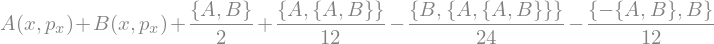

In [101]:
Aop.BCH(Bop,4).ham

The LieOperator class uses the PoissonBracket class for calculating the brackets, allowing expansion of the brackets.

In [106]:
PoissonBracket(A+B,C)

In [105]:
PoissonBracket(A+B,C).expand(commutator=True)


In [107]:
PoissonBracket(A*B,C)

In [109]:
PoissonBracket(A*B,C).expand(commutator=True)

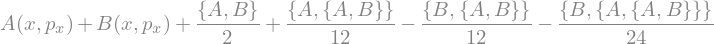

In [102]:
Aop.BCH(Bop,4).ham.expand(commutator=True)

# General

We  start by considering the following lattice:
$$A-B-C-D-E$$
where A,B,C,D,E are generic lattice elements and we consider the beam coming from the left (this important for the ordering of the operators).

The corresponding Lie map is given by:
$$e^{A}e^{B}e^{C}e^{D}e^{E}$$
and after the correct coordinate transformations this becomes:
$$e^{E}e^{D}e^{C}e^{B}e^{A}$$

The operators A,..,E in the exponents need to be combined using the BCH formula. Doing this order by order, where with order we mean the number of iterative Poisson brackets and not the order of the resulting polynomial in the independent coordinates, we get:
$$H_0 = A +B + C + D + E$$

For the higher orders we go step by step. Let us start by first having a look at $H_1$ for the first three elements.

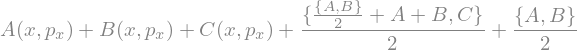

In [15]:
Aop.BCH(Bop,2).BCH(Cop,2).ham

Let us clean this up a bit by expanding the Poisson Brackets.

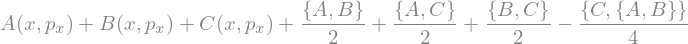

In [16]:
Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True)

One can immediately see the effect of the BCH formula, making things very complicated very quickly. 

An interesting question to ask is what happens if $C=A$.

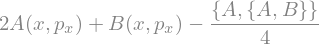

In [17]:
Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True).subs(C,A)

**The terms with a single Poisson bracket have been canceled out!**

Let us now break the symmetry lightly and assume that $C = A + \delta A$.

In [18]:
da = Function("\delta A", commutative=False)(x,px)
da

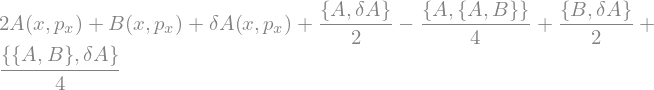

In [19]:
Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True).subs(C,A+da).expand(commutator=True)

Slightly breaking the symmetry between the elements $A$ and $C$ immediately introduces new terms
in the Hamiltonian:
$$2 A{\left(x,p_{x} \right)} + B{\left(x,p_{x} \right)} + \delta A{\left(x,p_{x} \right)} + 
\underbrace{\color{blue}{\frac{\lbrace A,\delta A \rbrace }{2}}}_{\color{red}{\text{SB1}}} 
- \frac{\lbrace A,\lbrace A,B \rbrace  \rbrace }{4} 
+ \underbrace{\color{blue}{\frac{\lbrace B,\delta A \rbrace }{2}}}_{\color{red}{\text{SB2}}}  + 
\underbrace{\color{gray}{\frac{\lbrace \lbrace A,B \rbrace ,\delta A \rbrace }{4}}}_{\color{red}{\text{SB3}}} $$
where SB stands for Symmetry Breaking. Note that these terms are directly proportional to the amount of symmetry breaking. 

In [20]:
print_latex(Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True).subs(C,A+da).expand(commutator=True))

2 A{\left(x,p_{x} \right)} + B{\left(x,p_{x} \right)} + \delta A{\left(x,p_{x} \right)} + \frac{\lbrace A,\delta A \rbrace }{2} - \frac{\lbrace A,\lbrace A,B \rbrace  \rbrace }{4} + \frac{\lbrace B,\delta A \rbrace }{2} + \frac{\lbrace \lbrace A,B \rbrace ,\delta A \rbrace }{4}


# Example QF-D

In [21]:
from sympy import NumberSymbol

class SymbolTrick(NumberSymbol):
    """
    https://stackoverflow.com/questions/39665207/define-a-variable-in-sympy-to-be-a-constant
    """
    def __new__(self, name):
        obj = NumberSymbol.__new__(self)
        obj._name = name
        return obj
    __str__ = lambda self: str(self._name)
    _as_mpf_val = 1.0
    
    def _latex(self, printer, *args):
        return r"{}".format(self._name)

In [22]:
LQ = SymbolTrick("L_Q")
LD = SymbolTrick("L_D")
kq1 = SymbolTrick("K_{Q_1}")
dkq1 = SymbolTrick("\delta{K_{Q_1}}")

In [23]:
# inserting replacements to ignore all planes besides x-px
rep = list(zip([delta, px, y, py],[0,0,0,0]))
hamq1 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1).subs(rep)
hamd  = HamDrift6DParaxialSecondOrder(beta0,gamma0,LD,x,px,y,py,delta).subs(delta,0).subs(py,0)

In [24]:
qdham = Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit()

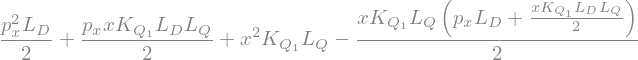

In [25]:
qdham

In [26]:
k=1.5
lq = .25
ld = 2
dk = .1
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))
qd_ham = qdham.subs(nrep)
qd_ham

<IPython.core.display.Javascript object>


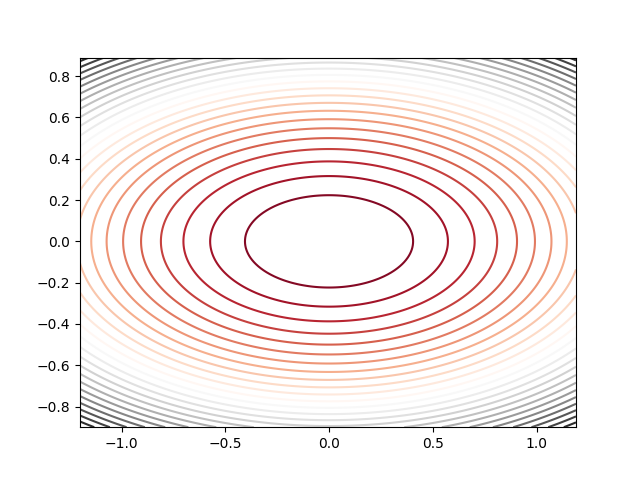

In [27]:
fig = plt.figure()
valx = 1.2
valpx = 0.9
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),qd_ham,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 30, cmap='RdGy')
plt.show()

In [28]:
# inserting replacements to ignore all planes besides x-px
rep = list(zip([delta, px, y, py],[0,0,0,0]))
hamq1 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1).subs(rep)
hamd  = HamDrift6D(beta0,gamma0,LD,x,px,y,py,delta).subs(delta,0).subs(py,0)

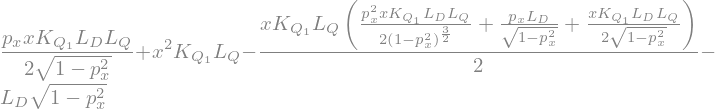

In [29]:
qdhamf = Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit().subs(beta0*gamma0,oo).subs(beta0,1)
qdhamf

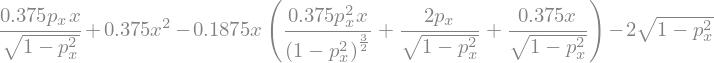

In [30]:
k=1.5
lq = .25
ld = 2
dk = -.5
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))
qd_hamf = qdhamf.subs(nrep)
qd_hamf

<IPython.core.display.Javascript object>


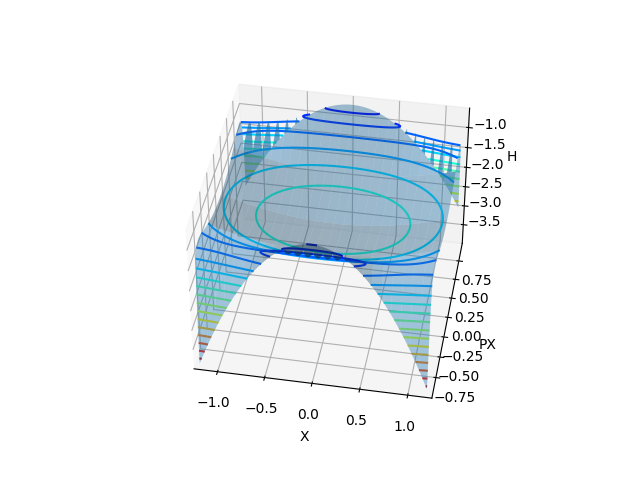

In [31]:

mg  = 50   # meshgrid size

fig = plt.figure()
ax = fig.gca(projection='3d')
valx = 1.2
valpx = 0.955
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),qd_hamf,"numpy")
H = ham(X, P)

ax.plot_surface(X, P, H,alpha=0.4,rstride=mg)
cset = ax.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(-valx, valx)
ax.set_ylabel('PX')
ax.set_ylim(-valpx, valpx)
ax.set_zlabel('H')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
plt.show()

<IPython.core.display.Javascript object>


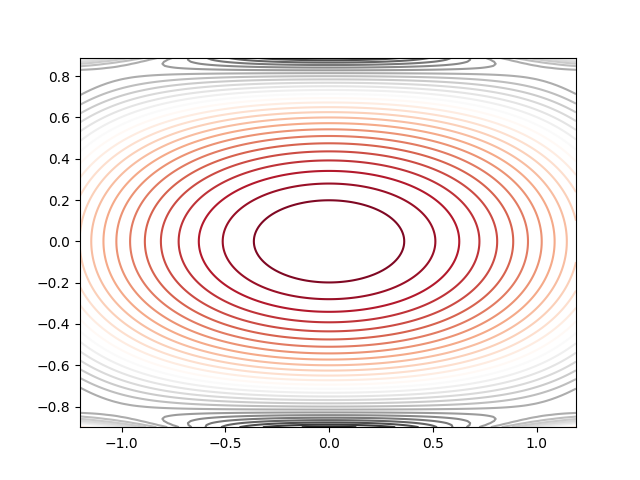

In [32]:
fig = plt.figure()
valx = 1.2
valpx = 0.9
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),qd_hamf,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 30, cmap='RdGy')
plt.show()

In [33]:
partialderiv_x= Derivative(qd_ham, x)
partialderiv_p= Derivative(qd_ham, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

{p_x: 0.0, x: 0.0}


In [34]:
partialderiv_x= Derivative(qd_hamf, x)
partialderiv_p= Derivative(qd_hamf, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

[(-1.00872383294860, -0.820004466892643), (-1.00872383294860, 0.820004466892643), (0.0, 0.0), (1.00872383294860, -0.820004466892643), (1.00872383294860, 0.820004466892643)]


# Example QF-D-QF

Let us apply this to an example, where we consider $A$ and $C$ to be quads and $B$ to be a drift space.
<img src="QDQ.png" alt = "test pic" style = "width:250px; height=900px;">

We confine ourselves to the $x-px$ plane and use thin lens approximations for the quadrupoles to not make things to complicated when the expressions are expanded. We also use the paraxial approximation for the Drift. The relevant Hamiltonians are then given by:
$$H_{Q_1}=\frac{L k_{Q1} x^{2}}{2} \\
H_{D}=\frac{L p_{x}^{2}}{2} \\
H_{Q_2}=L x^{2} \left(\frac{\delta{k_{Q1}}}{2} + \frac{k_{Q1}}{2}\right)
$$

In [35]:
from sympy import NumberSymbol

class SymbolTrick(NumberSymbol):
    """
    https://stackoverflow.com/questions/39665207/define-a-variable-in-sympy-to-be-a-constant
    """
    def __new__(self, name):
        obj = NumberSymbol.__new__(self)
        obj._name = name
        return obj
    __str__ = lambda self: str(self._name)
    _as_mpf_val = 1.0
    
    def _latex(self, printer, *args):
        return r"{}".format(self._name)

In [36]:
LQ = SymbolTrick("L_Q")
LD = SymbolTrick("L_D")
kq1 = SymbolTrick("K_{Q_1}")
dkq1 = SymbolTrick("\delta{K_{Q_1}}")

In [37]:
dkq1

In [38]:
# inserting replacements to ignore all planes besides x-px
rep = list(zip([delta, px, y, py],[0,0,0,0]))
hamq1 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1).subs(rep)
hamq2 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1+dkq1).subs(rep)
hamd  = HamDrift6DParaxialSecondOrder(beta0,gamma0,LD,x,px,y,py,delta).subs(delta,0).subs(py,0)

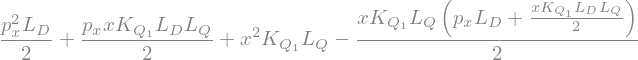

In [39]:
Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit()

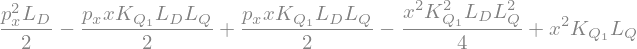

In [40]:
Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit().expand()

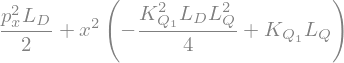

In [41]:
s_case = simplify(Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit()).expand().collect(x**2)
s_case

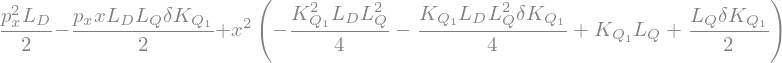

In [45]:
Aop.BCH(Bop,2).BCH(Cop,2).ham.subs(A,hamq1).subs(C,hamq2).subs(B,hamd).doit().expand().collect(x**2).collect(x*px)

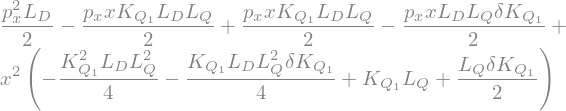

In [46]:
sb_case = Aop.BCH(Bop,2).BCH(Cop,2).ham.subs(A,hamq1).subs(C,hamq2).subs(B,hamd).doit().expand().collect(x**2)
sb_case

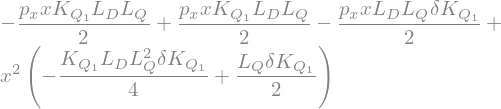

In [47]:
s_sb_diff = (sb_case-s_case).expand().collect(x**2)
s_sb_diff

In [48]:
Poly(s_sb_diff,x,px).coeff_monomial(x*px)

NameError: name 'Poly' is not defined

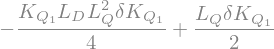

In [354]:
Poly(s_sb_diff,x,px).coeff_monomial(x*x)

In [49]:
k=1.5
lq = .25
ld = 2
dk = .1
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))
s_ham = s_case.subs(nrep)
sb_ham = sb_case.subs(nrep).subs(dkq1,dk)
s_ham, sb_ham

<IPython.core.display.Javascript object>


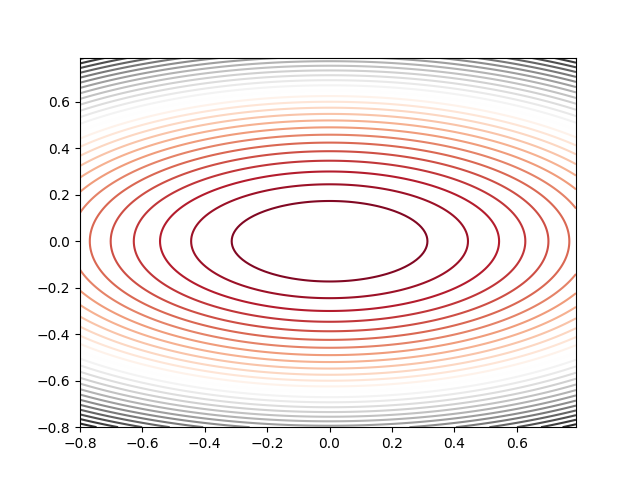

In [50]:
fig = plt.figure()
xx = np.arange(-0.8, 0.8, 0.01)
pxp = np.arange(-0.8, 0.8, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),s_ham,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 30, cmap='RdGy')
plt.show()

<IPython.core.display.Javascript object>


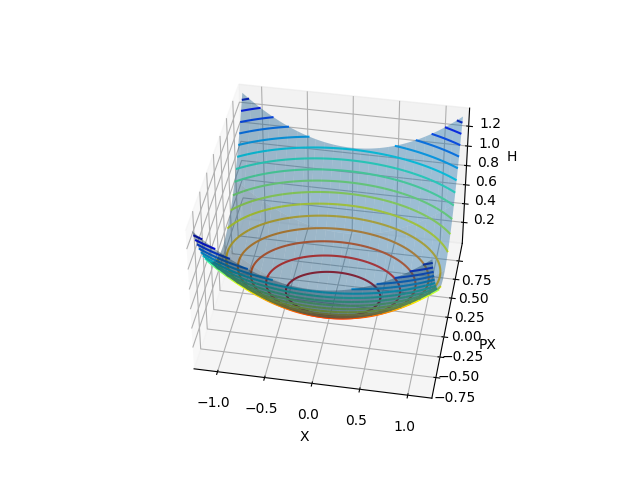

In [51]:

mg  = 50   # meshgrid size

fig = plt.figure()
ax = fig.gca(projection='3d')
valx = 1.2
valpx = 0.955
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),s_ham,"numpy")
H = ham(X, P)

ax.plot_surface(X, P, H,alpha=0.4,rstride=mg)
cset = ax.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(-valx, valx)
ax.set_ylabel('PX')
ax.set_ylim(-valpx, valpx)
ax.set_zlabel('H')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
plt.show()

<IPython.core.display.Javascript object>


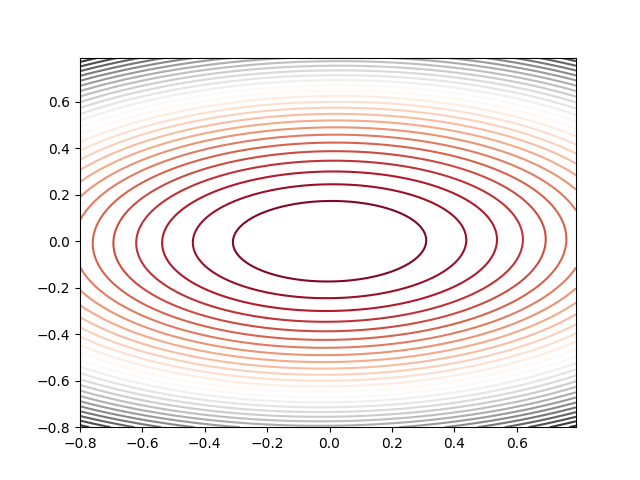

In [52]:
fig = plt.figure()
xx = np.arange(-0.8, 0.8, 0.01)
pxp = np.arange(-0.8, 0.8, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),sb_ham,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 30, cmap='RdGy')
plt.show()

<IPython.core.display.Javascript object>


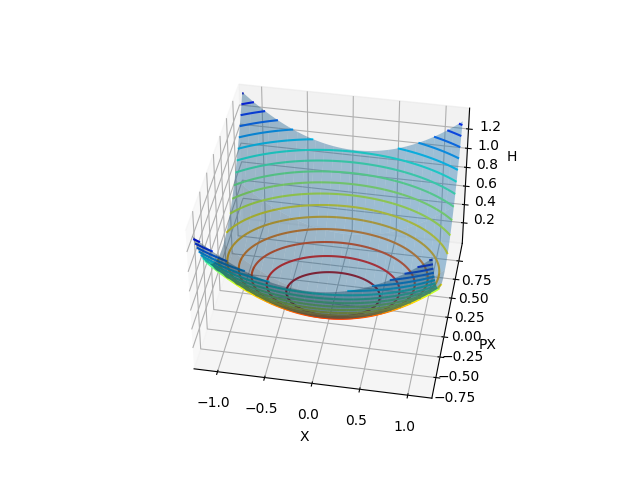

In [53]:

mg  = 50   # meshgrid size

fig = plt.figure()
ax = fig.gca(projection='3d')
valx = 1.2
valpx = 0.955
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),sb_ham,"numpy")
H = ham(X, P)

ax.plot_surface(X, P, H,alpha=0.4,rstride=mg)
cset = ax.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(-valx, valx)
ax.set_ylabel('PX')
ax.set_ylim(-valpx, valpx)
ax.set_zlabel('H')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
plt.show()

In [411]:
partialderiv_x= Derivative(s_ham, x)
partialderiv_p= Derivative(s_ham, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

{p_x: 0.0, x: 0.0}


In [412]:
partialderiv_x= Derivative(sb_ham, x)
partialderiv_p= Derivative(sb_ham, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

{p_x: 0.0, x: 0.0}


# Using full hamiltonian for drift

In [54]:
rep = list(zip([delta, px, y, py],[0,0,0,0]))
hamq1 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1).subs(rep)
hamq2 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1+dkq1).subs(rep)
hamd  = HamDrift6D(beta0,gamma0,LD,x,px,y,py,delta).subs(delta,0).subs(py,0).subs(beta0*gamma0,oo).subs(beta0,1)
hamd

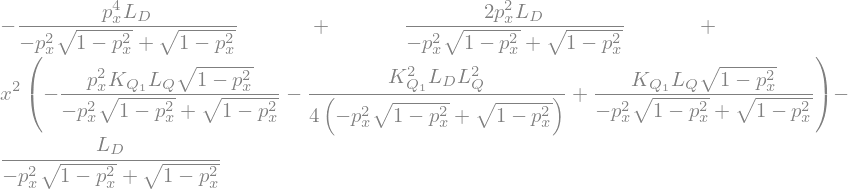

In [55]:
s_casef = simplify(Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit()).expand().collect(x**2)
s_casef

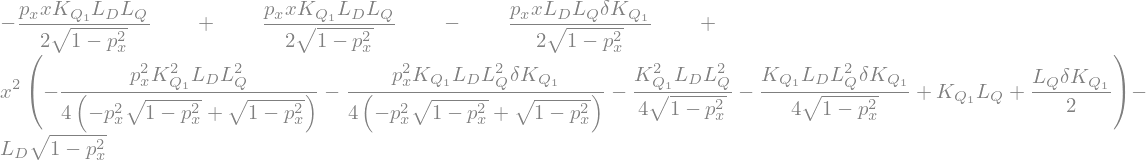

In [57]:
sb_casef = Aop.BCH(Bop,2).BCH(Cop,2).ham.subs(A,hamq1).subs(C,hamq2).subs(B,hamd).doit().expand().collect(x**2)
sb_casef

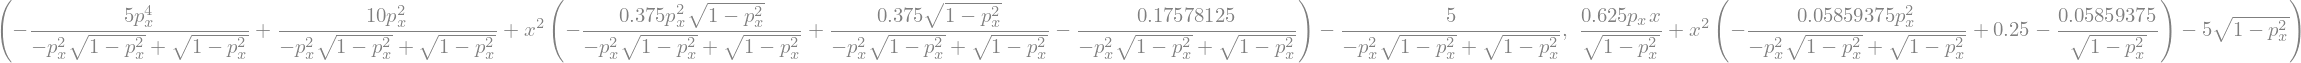

In [86]:
k=1.5
lq = .25
ld = 5
dk = -1.
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))
s_hamf = s_casef.subs(nrep)
sb_hamf = sb_casef.subs(nrep).subs(dkq1,dk)
s_hamf, sb_hamf

<IPython.core.display.Javascript object>


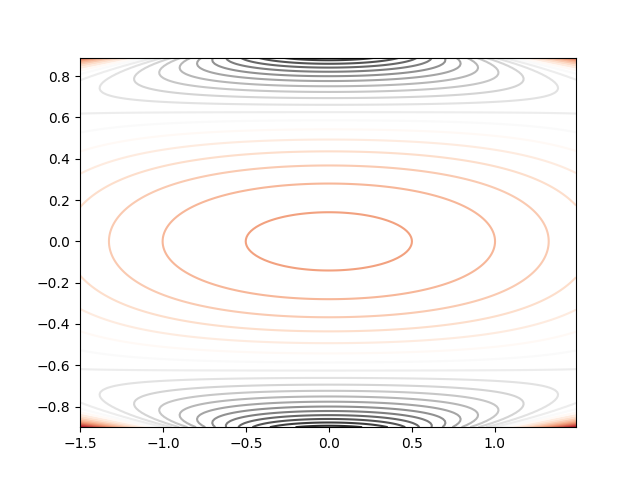

In [87]:
fig = plt.figure()
xx = np.arange(-1.5, 1.5, 0.01)
pxp = np.arange(-0.9, 0.9, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),s_hamf,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 30, cmap='RdGy')
plt.show()

<IPython.core.display.Javascript object>


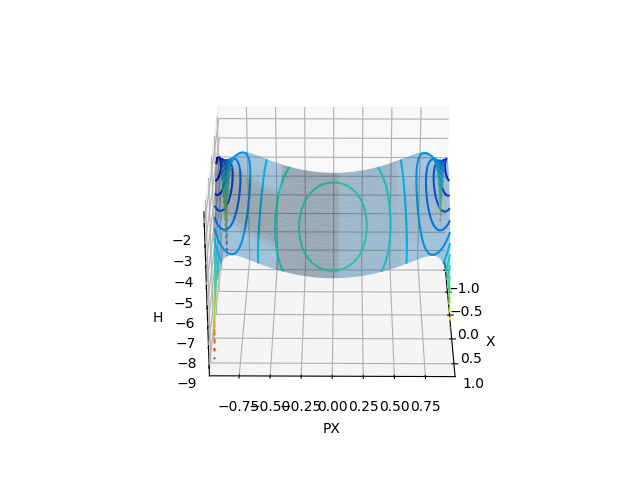

In [92]:
mg  = 50   # meshgrid size

fig = plt.figure()
ax = fig.gca(projection='3d')
valx = 1.2
valpx = 0.95
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),s_hamf,"numpy")
H = ham(X, P)

ax.plot_surface(X, P, H,alpha=0.4,rstride=mg)
cset = ax.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(-valx, valx)
ax.set_ylabel('PX')
ax.set_ylim(-valpx, valpx)
ax.set_zlabel('H')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
plt.show()

<IPython.core.display.Javascript object>


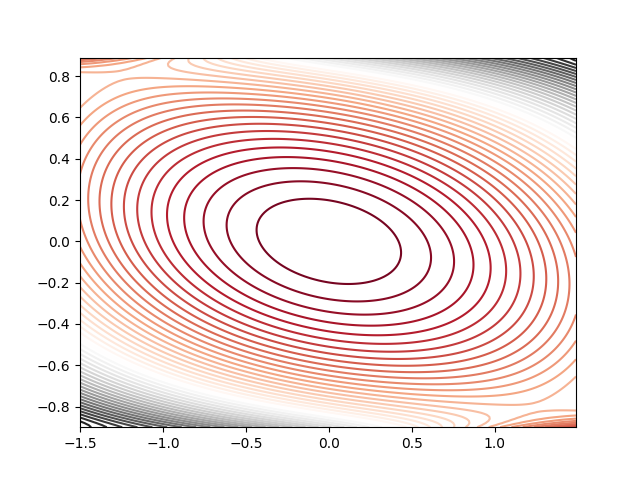

In [61]:
fig = plt.figure()
xx = np.arange(-1.5, 1.5, 0.01)
pxp = np.arange(-0.9, 0.9, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),sb_hamf,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 50, cmap='RdGy')
plt.show()

<IPython.core.display.Javascript object>


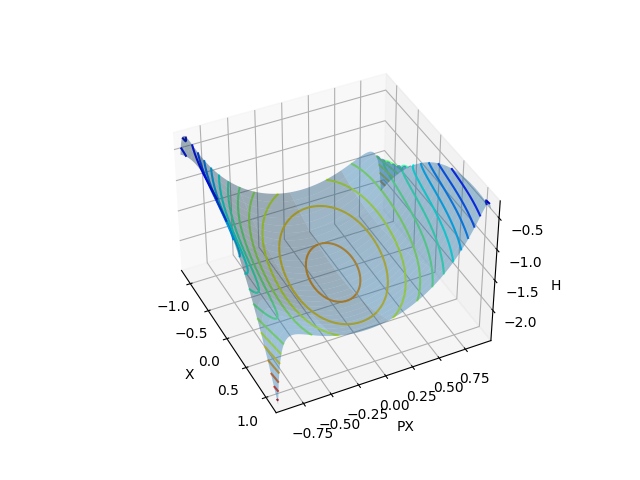

In [62]:
mg  = 50   # meshgrid size

fig = plt.figure()
ax = fig.gca(projection='3d')
valx = 1.2
valpx = 0.955
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),sb_hamf,"numpy")
H = ham(X, P)

ax.plot_surface(X, P, H,alpha=0.4,rstride=mg)
cset = ax.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(-valx, valx)
ax.set_ylabel('PX')
ax.set_ylim(-valpx, valpx)
ax.set_zlabel('H')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
plt.show()

In [63]:
partialderiv_x= Derivative(s_hamf, x)
partialderiv_p= Derivative(s_hamf, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

[(-1.00872383294860, -0.820004466892643), (-1.00872383294860, 0.820004466892643), (0.0, 0.0), (1.00872383294860, -0.820004466892643), (1.00872383294860, 0.820004466892643)]


In [64]:
partialderiv_x= Derivative(sb_hamf, x)
partialderiv_p= Derivative(sb_hamf, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

[]


In [77]:
from scipy.optimize import fsolve
fxfp = lambdify((x,px),H_x,"numpy")
fpfp = lambdify((x,px),H_p,"numpy")
def func(m):
    return [fxfp(m[0],m[1]),fpfp(m[0],m[1])]
    
fsolve(func,[0.9,-0.8]), fsolve(func,[-.9,.8])

(array([ 1.24721735, -0.80640616]), array([-1.24721735,  0.80640616]))

In [66]:
solve( (x_FP, p_FP), x, px )

# Generating plots

In [47]:
lattice = {
    "Q1": {
        "l" : 0.25,
        "class": "QUADRUPOLE",
        "k1": 1.5,
        "k2": 0.0,
        "angle": 0.0,
        "center pos": 0.125
    },
    "D": {
        "l" : 5.0,
        "class": "DRIFT",
        "k1": 0.0,
        "k2": 0.0,
        "angle": 0.0,
        "center pos": 2.75
    },
    "Q2": {
        "l" : 0.25,
        "class": "QUADRUPOLE",
        "k1": 1.5,
        "k2": 0.0,
        "angle": 0.0,
        "center pos": 5.375
    },
    
}

In [33]:
lattice = pd.DataFrame(
    {
        "class" : ["QUADRUPOLE", "DRIFT", "QUADRUPOLE"],
        "NAME" : ["Q1","D","Q2"],
        "l":        [0.25,5,0.25],
        "k1":      [1.5, 0, 1.5]
        
    }
)
lattice["end_pos"] = lattice['l'].cumsum()
lattice["at"] = lattice['end_pos']- lattice['l']/2
lattice

,class,NAME,l,k1,end_pos,at
0,QUADRUPOLE,Q1,0.25,1.5,0.25,0.125
1,DRIFT,D,5.00,0.0,5.25,2.750
2,QUADRUPOLE,Q2,0.25,1.5,5.50,5.375


In [34]:
from AcceleratorPlotTools.AcceleratorPlotTools import plot_lattice

<IPython.core.display.Javascript object>


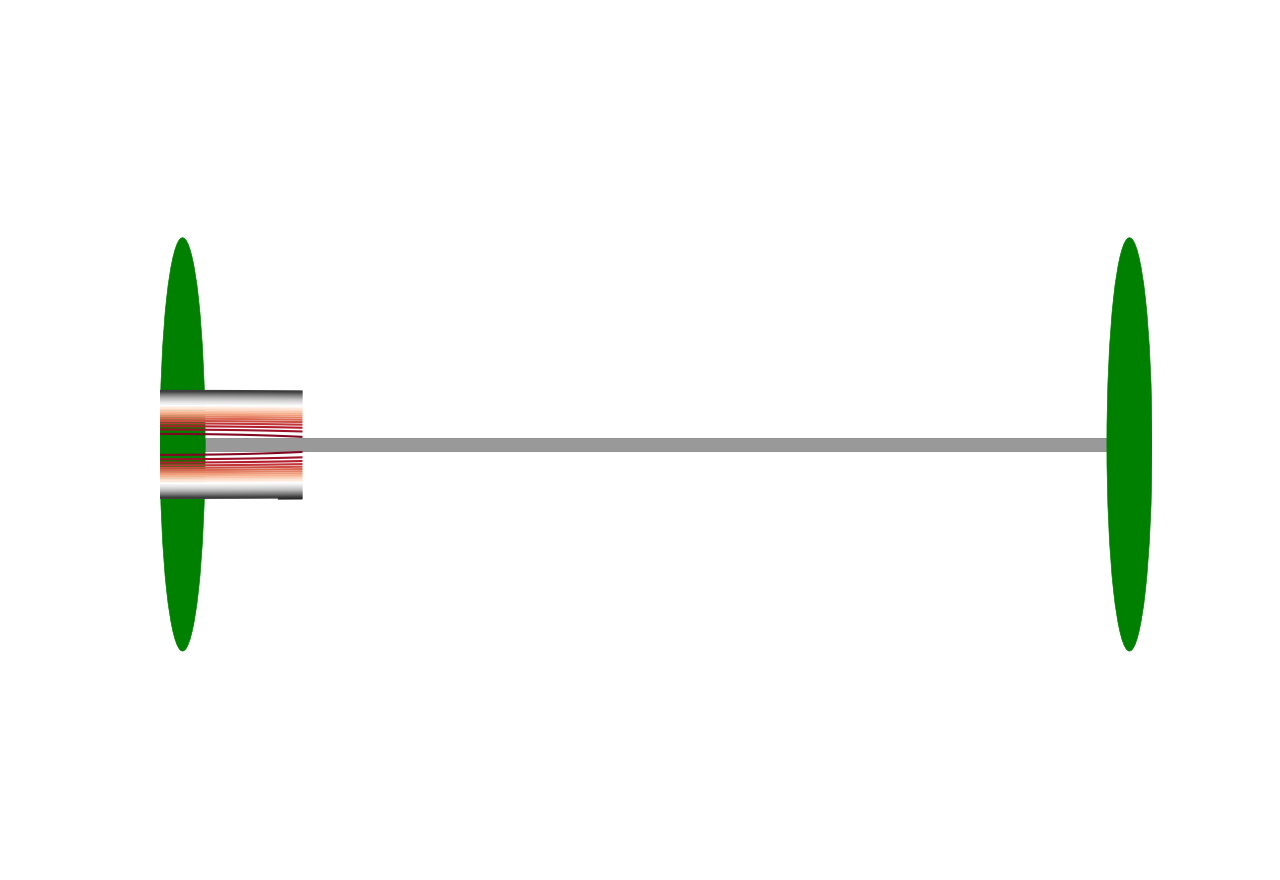

Q1          ,  0.2500,  0.2500,QUADRUPOLE  
D           ,  5.2500,  5.0000,DRIFT       
Q2          ,  5.5000,  0.2500,QUADRUPOLE  


In [69]:
plot_lattice(lattice, params={"kmax": .5, "ang_max": 1.5e-2, "smax": 10.0})
plt.grid(False)
plt.axis("Off")
plt.savefig("QDQ.png")

fig

<IPython.core.display.Javascript object>


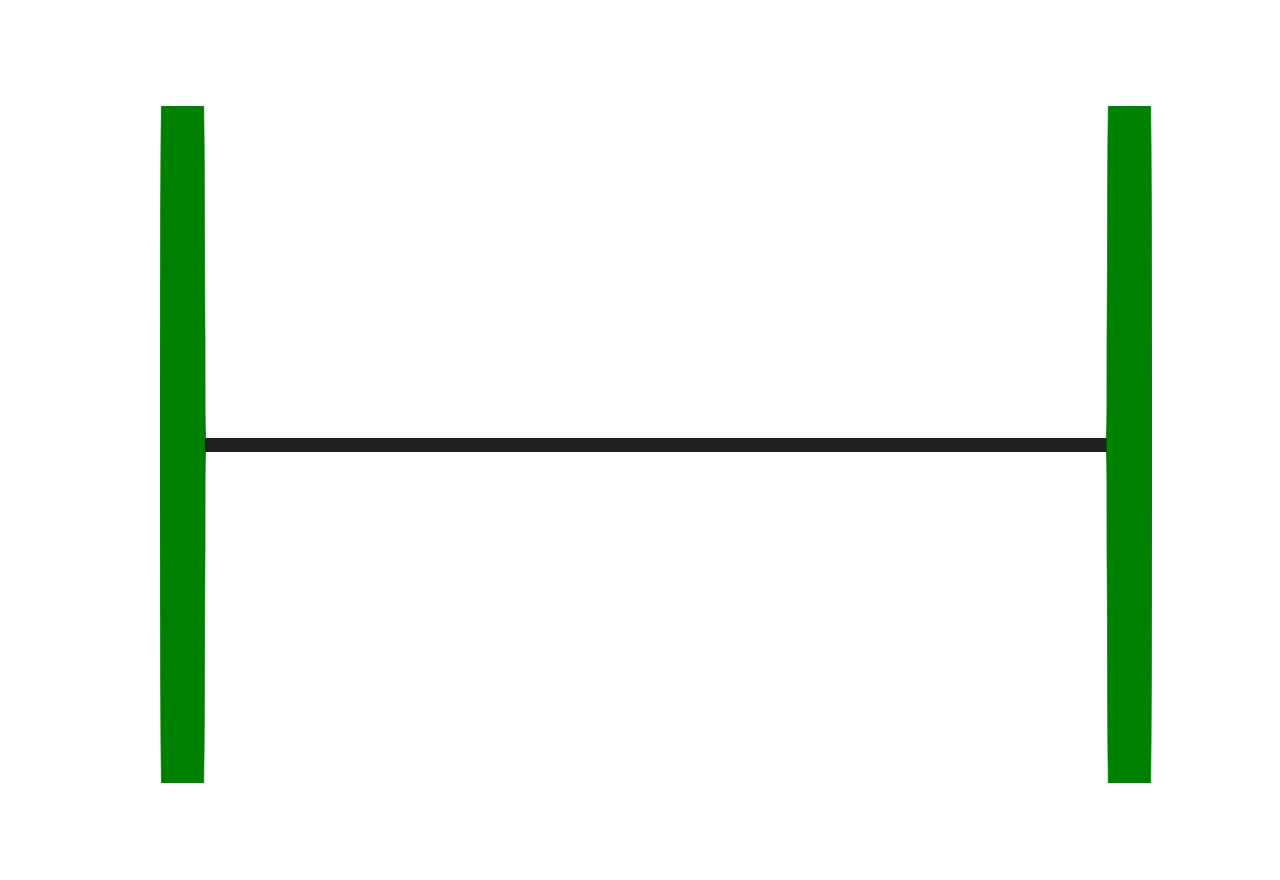

In [61]:
fig